In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, DecisionTreeClassifier 
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

dataframe_mysql = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost:3306/BreastCancer",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "mytable",
    user="root",
    password="8056").load()

In [4]:
dataframe_mysql.columns

['id',
 'diagnosis',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst',
 'FIELD33']

In [5]:
type(dataframe_mysql)

pyspark.sql.dataframe.DataFrame

In [6]:
dataframe_mysql.na.drop()

DataFrame[id: int, diagnosis: string, radius_mean: decimal(5,3), texture_mean: decimal(5,2), perimeter_mean: decimal(5,2), area_mean: decimal(5,1), smoothness_mean: decimal(7,5), compactness_mean: decimal(7,5), concavity_mean: decimal(9,7), concave_points_mean: decimal(8,6), symmetry_mean: decimal(6,4), fractal_dimension_mean: decimal(7,5), radius_se: decimal(6,4), texture_se: decimal(6,4), perimeter_se: decimal(6,4), area_se: decimal(6,3), smoothness_se: decimal(8,6), compactness_se: decimal(8,6), concavity_se: decimal(9,7), concave_points_se: decimal(8,6), symmetry_se: decimal(8,6), fractal_dimension_se: decimal(9,7), radius_worst: decimal(5,3), texture_worst: decimal(5,2), perimeter_worst: decimal(5,2), area_worst: decimal(5,1), smoothness_worst: decimal(7,5), compactness_worst: decimal(7,5), concavity_worst: decimal(8,6), concave_points_worst: decimal(8,6), symmetry_worst: decimal(6,4), fractal_dimension_worst: decimal(7,5), FIELD33: string]

In [7]:
dataframe_mysql.count()

569

In [8]:
dataframe_mysql = dataframe_mysql.withColumn("diagnosis", when(col("diagnosis") == "M", 1).otherwise(0))
dataframe_mysql.show()

+-----+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-------+
|   id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|FIELD33|
+-----+---------+-----------+---------

In [9]:
dataframe_mysql.filter(dataframe_mysql['diagnosis'] == 1).select('diagnosis').count()
print(dataframe_mysql.filter(dataframe_mysql['diagnosis'] == 1).select('diagnosis').count(), "malignant", sep=" ")
print(dataframe_mysql.filter(dataframe_mysql['diagnosis'] == 0).select('diagnosis').count(), "otherwise", sep=" ")

212 malignant
357 otherwise


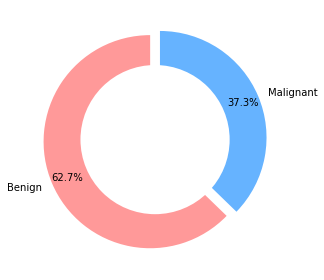

In [10]:
labels = ['Benign', 'Malignant']
sizes = [dataframe_mysql.filter(dataframe_mysql['diagnosis'] == 0).select('diagnosis').count(), dataframe_mysql.filter(dataframe_mysql['diagnosis'] == 1).select('diagnosis').count()]
colors = ['#ff9999','#66b3ff']
explode = (0.05,0.05)

plt.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

In [11]:
print(dataframe_mysql.describe().show())

+-------+--------------------+-------------------+-----------------+-----------------+----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-----------------+-----------------+------------------+-----------------+--------------------+------------------+------------------+--------------------+-------------------+-----------------------+-------+
|summary|                  id|          diagnosis|      radius_mean|     texture_mean|  perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave_points_mean|       symmetry_mean|fractal_dimension_mean|        radius_se|        texture_se|     perimeter_se|           area_se|       smoothness_se|      c

In [12]:
dataframe_mysql.dropna().count()

0

In [13]:
print(dataframe_mysql.columns[3:-1])

['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [14]:

selected_features = dataframe_mysql.select(
                                'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst')

assembler = VectorAssembler(inputCols=selected_features.columns,
                           outputCol='features',
                           handleInvalid='skip')
dataframe_mysql= assembler.transform(dataframe_mysql)
dataframe_mysql.show(5)

+-----+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-------+--------------------+
|   id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|FIELD33|            featur

In [15]:
scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)


In [16]:
scale_data = scaler1.fit(dataframe_mysql).transform(dataframe_mysql)

In [17]:
print(scale_data.columns)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'FIELD33', 'features', 'scaledFeatures']


In [18]:

train_df, test_df = scale_data.select('id', 'diagnosis','scaledFeatures').randomSplit([0.8,0.2], seed=140)

In [19]:
train_df.count()

456

In [20]:
test_df.count()

113

In [21]:
train_df.show(5)

+-----+---------+--------------------+
|   id|diagnosis|      scaledFeatures|
+-----+---------+--------------------+
| 8915|        0|[-0.0440936826321...|
| 9047|        0|[-0.7253249389927...|
|85715|        1|[-0.1463946221538...|
|86208|        1|[0.86963970900501...|
|86355|        1|[0.08843253447552...|
+-----+---------+--------------------+
only showing top 5 rows



In [22]:
# train_df = train_df.drop('id')
# test_df = test_df.drop('id')

In [23]:
train_df.show(5)

+-----+---------+--------------------+
|   id|diagnosis|      scaledFeatures|
+-----+---------+--------------------+
| 8915|        0|[-0.0440936826321...|
| 9047|        0|[-0.7253249389927...|
|85715|        1|[-0.1463946221538...|
|86208|        1|[0.86963970900501...|
|86355|        1|[0.08843253447552...|
+-----+---------+--------------------+
only showing top 5 rows



In [24]:

lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'diagnosis')
lr_model = lr.fit(train_df)
# predictionslr = lr.train(test_df)

In [25]:
lr_model.transform(test_df).show(5)


+-----+---------+--------------------+--------------------+-----------+----------+
|   id|diagnosis|      scaledFeatures|       rawPrediction|probability|prediction|
+-----+---------+--------------------+--------------------+-----------+----------+
| 8670|        1|[0.04425712877296...|[-5580.0381502201...|  [0.0,1.0]|       1.0|
| 8913|        0|[-1.4344564515864...|[7396.46007775784...|  [1.0,0.0]|       0.0|
|86211|        0|[-0.3370463730807...|[4810.50688794197...|  [1.0,0.0]|       0.0|
|87127|        0|[-2.2272887328797...|[7444.88543401125...|  [1.0,0.0]|       0.0|
|87930|        0|[-0.1603447502704...|[314.315431065042...|  [1.0,0.0]|       0.0|
+-----+---------+--------------------+--------------------+-----------+----------+
only showing top 5 rows



In [26]:
predictionslr = lr_model.transform(test_df)

In [27]:

lrpredictB = predictionslr[predictionslr.prediction==0].toPandas()
lrpredictM = predictionslr[predictionslr.prediction==1].toPandas()

In [28]:
result = pd.concat([lrpredictB,lrpredictM])
true_labels=(test_df.orderBy("id").select("diagnosis")).toPandas()
predicted_labels=result.sort_values("id")["prediction"]

print("-- Logistic Regression --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
LR=confusion_matrix(true_labels,predicted_labels)

-- Logistic Regression --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.97      0.96      0.97        76
           1       0.92      0.95      0.93        37

    accuracy                           0.96       113
   macro avg       0.95      0.95      0.95       113
weighted avg       0.96      0.96      0.96       113

------------------------------------------------------------------------
Confusion matrix
 [[73  3]
 [ 2 35]] 




In [29]:
dc = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'diagnosis')
dc_model = dc.fit(train_df)
predictionsdc = dc_model.transform(test_df)

In [30]:

dcpredictB = predictionsdc[predictionsdc.prediction==0].toPandas()
dcpredictM = predictionsdc[predictionsdc.prediction==1].toPandas()

In [31]:
result = pd.concat([dcpredictB,dcpredictM])
true_labels=(test_df.orderBy("id").select("diagnosis")).toPandas()
predicted_labels=result.sort_values("id")["prediction"]

print("-- Decision Tree Classifier --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
DC=confusion_matrix(true_labels,predicted_labels)

-- Decision Tree Classifier --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        76
           1       0.90      0.95      0.92        37

    accuracy                           0.95       113
   macro avg       0.94      0.95      0.94       113
weighted avg       0.95      0.95      0.95       113

------------------------------------------------------------------------
Confusion matrix
 [[72  4]
 [ 2 35]] 




In [32]:
rfc = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'diagnosis')
rfc_model = rfc.fit(train_df)
predictionsrfc = rfc_model.transform(test_df)

In [33]:

rfccpredictB = predictionsrfc[predictionsrfc.prediction==0].toPandas()
rfccpredictM = predictionsrfc[predictionsrfc.prediction==1].toPandas()

In [34]:
result = pd.concat([rfccpredictB,rfccpredictM])
true_labels=(test_df.orderBy("id").select("diagnosis")).toPandas()
predicted_labels=result.sort_values("id")["prediction"]

print("-- Random Forest Classifier --")
print("------------------------------------------------------------------------")
print("Classification Report\n",classification_report(true_labels, predicted_labels))
print("------------------------------------------------------------------------")
print("Confusion matrix\n",confusion_matrix(true_labels,predicted_labels),"\n\n")
DC=confusion_matrix(true_labels,predicted_labels)

-- Random Forest Classifier --
------------------------------------------------------------------------
Classification Report
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        76
           1       0.97      0.92      0.94        37

    accuracy                           0.96       113
   macro avg       0.97      0.95      0.96       113
weighted avg       0.96      0.96      0.96       113

------------------------------------------------------------------------
Confusion matrix
 [[75  1]
 [ 3 34]] 




In [35]:
from pandas_profiling import ProfileReport

profile = ProfileReport(dataframe_mysql.toPandas())

In [38]:
profile.to_file("output.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]